In [1]:
from scipy.io import loadmat
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import numpy as np
import os
import collections

import sys
sys.path.append("../")
from ModelConstants import OriginalConstants as mc

def my_savefig(file_name):
    plt.savefig(os.path.join(os.getenv('DA_FIGURES', ''), f"{file_name}.pdf"), bbox_inches='tight')
    plt.savefig(os.path.join(os.getenv('DA_FIGURES', ''), f"{file_name}.svg"), bbox_inches='tight')

def Fr(w, p1, q1, p2, q2):
    cond_1 = w <= -2 * q2 / p2
    expr_1 = p2 * w + q2
    cond_2 = w <= 0
    expr_2 = - p2 ** 2 / (4 * q2) * w ** 2
    cond_3 = w <= 2 * q1 / p1
    expr_3 = p1 ** 2 / (4 * q1) * w ** 2
    cond_4 = True
    expr_4 = p1 * w - q1

    if cond_1:
        return expr_1
    elif cond_2:
        return expr_2
    elif cond_3:
        return expr_3
    elif cond_4:
        return expr_4
    
def Fr_inverse(F, p1, q1, p2, q2):
    if F <= - q2:
        return (F - q2) / p2
    elif F < 0:
        return - np.sqrt(-4*q2*F) / p2
    elif F < q1:
        return np.sqrt(4*q1*F) / p1
    else:
        return (F + q1) / p1
    
def load_meas(file_name):
    MeasData = collections.namedtuple('MeasData', ['t', 'vf', 'vb',
                                                   'meas_phi', 'meas_eps', 'meas_lamb',
                                                   'enable_ramping',
                                                   'est_phi', 'est_eps', 'est_lamb',
                                                   'est_dphi', 'est_deps', 'est_dlamb',
                                                   'est_phi_off',
                                                   'traj_t',
                                                   'traj_vf', 'traj_vb',
                                                   'traj_phi', 'traj_eps', 'traj_lamb'])
    
    file = loadmat(f"../matlab/measurements/{file_name}")
    
    traj_t = file['t'].flatten()
    traj_phi = file['phi']
    traj_eps = file['eps']
    traj_lamb = file['lamb']
    traj_vf = file['vf']
    traj_vb = file['vb']
    
    log = file['log']
    
    t = log['time'][0][0].flatten()
    
    values = log['signals'][0][0]['values'][0]
    
    vf = values[0].flatten()
    vb = values[1].flatten()
    meas_phi = values[2].flatten()
    meas_eps = values[3].flatten()
    meas_lamb = values[4].flatten()
    enable_ramping = values[5].flatten() if len(values) >= 6 else np.zeros(len(t))
    est_phi = values[6].flatten() if len(values) >= 7 else np.zeros(len(t))
    est_eps = values[7].flatten() if len(values) >= 8 else np.zeros(len(t))
    est_lamb = values[8].flatten() if len(values) >= 9 else np.zeros(len(t))
    est_dphi = values[9].flatten() if len(values) >= 10 else np.zeros(len(t))
    est_deps = values[10].flatten() if len(values) >= 11 else np.zeros(len(t))
    est_dlamb = values[11].flatten() if len(values) >= 12 else np.zeros(len(t))
    est_phi_off = values[12].flatten() if len(values) >= 13 else np.zeros(len(t))
    
    return MeasData(t, vf, vb, meas_phi, meas_eps, meas_lamb, enable_ramping,
                    est_phi, est_eps, est_lamb, est_dphi, est_deps, est_dlamb, est_phi_off,
                    traj_t, traj_vf, traj_vb, traj_phi, traj_eps, traj_lamb)

def clip_and_unify(meas_data, clip_start=None, clip_end=None, relative_to_traj_start=True, normalize_t=True, resample=True):
    Clip = collections.namedtuple('Clip', ['t', 'vf', 'vb',
                                           'phi', 'eps', 'lamb',
                                           'dphi', 'deps', 'dlamb', 'phioff',
                                           'traj_vf', 'traj_vb',
                                           'traj_phi', 'traj_eps', 'traj_lamb',
                                           'traj_start', 'traj_end'])
    
    traj_times = meas_data.t[meas_data.enable_ramping == -1]
    if len(traj_times) > 0:
        traj_start = traj_times[0]
        traj_end = traj_times[-1]
    else:
        traj_start = meas_data.t[0]
        traj_end = meas_data.t[-1]
    
    if relative_to_traj_start:
        if clip_start is None:
            clip_start = traj_start
        else:
            clip_start = clip_start + traj_start
            
        if clip_end is None:
            clip_end = traj_end
        else:
            clip_end = clip_end + traj_start
    else:
        if clip_start is None:
            clip_start = 0
        if clip_end is None:
            clip_end = meas_data.t[-1]
    
    clip_indices = (meas_data.t >= clip_start) & (meas_data.t <= clip_end)
    clip_t_unnormalized = meas_data.t[clip_indices] 
    if normalize_t:
        clip_t = clip_t_unnormalized - clip_start
        clip_traj_start = traj_start - clip_start
        clip_traj_end = traj_end - clip_start
    else:
        clip_t = clip_t_unnormalized
        clip_traj_start = traj_start
        clip_traj_end = traj_end
    clip_vf = meas_data.vf[clip_indices]
    clip_vb = meas_data.vb[clip_indices]
    clip_phi = meas_data.est_phi[clip_indices]
    clip_eps = meas_data.est_eps[clip_indices]
    clip_lamb = meas_data.est_lamb[clip_indices]   
    clip_dphi = meas_data.est_dphi[clip_indices]
    clip_deps = meas_data.est_deps[clip_indices]
    clip_dlamb = meas_data.est_dlamb[clip_indices]
    clip_phioff = meas_data.est_phi_off[clip_indices]
    traj_t_shifted = meas_data.traj_t + traj_start
    
    
    traj_vf_interp = interp1d(traj_t_shifted, meas_data.traj_vf,
                               bounds_error=False, fill_value=(meas_data.traj_vf[0], meas_data.traj_vf[-1]), axis=0)
    clip_traj_vf = traj_vf_interp(clip_t_unnormalized)
    traj_vb_interp = interp1d(traj_t_shifted, meas_data.traj_vb,
                               bounds_error=False, fill_value=(meas_data.traj_vb[0], meas_data.traj_vb[-1]), axis=0)
    clip_traj_vb = traj_vb_interp(clip_t_unnormalized)
    traj_phi_interp = interp1d(traj_t_shifted, meas_data.traj_phi,
                               bounds_error=False, fill_value=(meas_data.traj_phi[0], meas_data.traj_phi[-1]), axis=0)
    clip_traj_phi = traj_phi_interp(clip_t_unnormalized)
    traj_eps_interp = interp1d(traj_t_shifted, meas_data.traj_eps,
                               bounds_error=False, fill_value=(meas_data.traj_eps[0], meas_data.traj_eps[-1]), axis=0)
    clip_traj_eps = traj_eps_interp(clip_t_unnormalized)
    traj_lamb_interp = interp1d(traj_t_shifted, meas_data.traj_lamb,
                               bounds_error=False, fill_value=(meas_data.traj_lamb[0], meas_data.traj_lamb[-1]), axis=0)
    clip_traj_lamb = traj_lamb_interp(clip_t_unnormalized)
    
    if resample:
        clip_t = clip_t[::10]
        clip_vf = clip_vf[::10]
        clip_vb = clip_vb[::10]
        clip_phi = clip_phi[::10]
        clip_eps = clip_eps[::10]
        clip_lamb = clip_lamb[::10]
        clip_dphi = clip_dphi[::10]
        clip_deps = clip_deps[::10]
        clip_dlamb = clip_dlamb[::10]
        clip_phioff = clip_phioff[::10]
        clip_traj_vf = clip_traj_vf[::10]
        clip_traj_vb = clip_traj_vb[::10]
        clip_traj_phi = clip_traj_phi[::10]
        clip_traj_eps = clip_traj_eps[::10]
        clip_traj_lamb = clip_traj_lamb[::10]
    
    return Clip(clip_t, clip_vf, clip_vb,
                clip_phi, clip_eps, clip_lamb,
                clip_dphi, clip_deps, clip_dlamb, clip_phioff,
                clip_traj_vf, clip_traj_vb,
                clip_traj_phi, clip_traj_eps, clip_traj_lamb,
                clip_traj_start, clip_traj_end)

def load_est(file_name):
    EstData = collections.namedtuple('EstData', ['params', 'clips'])
    ClipData = collections.namedtuple('ClipData', ['meas_t', 'meas_u', 'meas_y', 'sim_y'])
    
    file = loadmat(f"../matlab/{file_name}")
    
    params = file['params'].flatten()
    clips = []
    
    for i in range(len(file['clips'][0])):
        clip = file['clips'][0,i]
        meas_t = clip['meas_t'].flatten()
        meas_u = clip['meas_u']
        meas_y = clip['meas_y']
        sim_y = clip['sim_y']
        
        clips.append(ClipData(meas_t, meas_u, meas_y, sim_y))
    
    return EstData(params, clips)

def plot_est(file_name, clip_nr, angle, with_input=True):
    deg = np.pi / 180
    data = load_est(file_name)
    
    if with_input:
        ax1 = plt.subplot(211)
    plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].meas_y/deg, label='measured')
    plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].sim_y/deg, label='simulated')
    plt.xlabel('$t$ [s]')
    plt.ylabel(f"$\\{angle}$ [°]")
    plt.grid()
    plt.legend()
    
    if with_input:
        plt.subplot(212, sharex=ax1)
        plt.plot(data.clips[clip_nr].meas_t, data.clips[clip_nr].meas_u)
        plt.xlabel('$t$ [s]')
        plt.ylabel('$V$ [V]')
        plt.grid()
        plt.legend(['$V_\\mathrm{f}$', '$V_\\mathrm{b}$'])
        squeeze_subplots()
        
def label_and_stuff(label_y=True, legend=True):
    plt.grid()
    if legend:
        plt.legend()
    plt.xlabel("$t$ [s]")
    if label_y:
        plt.ylabel("angle [°]")
    
def squeeze_subplots():
    for ax in plt.gcf().axes:
        try:
            ax.label_outer()
        except:
            pass

    plt.tight_layout()
    
def static_ff_voltage(eps):
    Fs = mc.g/mc.l_h*((mc.m_c*mc.d_c-mc.m_h*mc.d_h)*np.sin(eps)+(mc.m_h*mc.l_h-mc.m_c*mc.l_c)*np.cos(eps))
    Fr = Fs/2
    V = Fr_inverse(Fr, mc.p1, mc.q1, mc.p2, mc.q2)
    return V

def plot_traj(clip):
    ax1 = plt.subplot(311)
    plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color)
    plt.plot(clip.t, clip.traj_phi[:, 0]/deg, label="$\\varphi^*$", **phi_color, ls='--')
    plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
    plt.plot(clip.t, clip.traj_eps[:, 0]/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
    plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
    plt.plot(clip.t, clip.traj_lamb[:, 0]/deg, label="$\\lambda^*$", **lamb_color, ls='--')
    plt.ylabel("angle [°]")
    plt.grid()
    plt.legend(**leg)
    
    plt.subplot(312)
    plt.plot(clip.t, (clip.eps - clip.traj_eps[:, 0])/deg, label="$\\tilde\\varepsilon$", **eps_color)
    plt.plot(clip.t, (clip.lamb - clip.traj_lamb[:, 0])/deg, label="$\\tilde\\lambda$", **lamb_color)
    plt.ylabel("angle error [°]")
    plt.grid()
    plt.legend(**leg)
    
    plt.subplot(313, sharex=ax1)
    plt.step(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
    plt.plot(clip.t, clip.traj_vf, label="$V_\\mathrm{f}^*$", **vf_color, ls='--')
    plt.step(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
    plt.plot(clip.t, clip.traj_vb, label="$V_\\mathrm{b}^*$", **vb_color, ls='--')
    plt.xlabel("$t$ [s]")
    plt.ylabel('input voltage [V]')
    plt.grid()
    plt.legend(**leg)
    
    squeeze_subplots()

deg = np.pi / 180
phi_color = dict(color='#6175f9')
phi_alt_color = dict(color='#203cf7')
eps_color = dict(color='#6fc33b')
eps_alt_color = dict(color='#518f2b')
lamb_color = dict(color='#a164ed')
lamb_alt_color = dict(color='#7c27e6')
vf_color = dict(color='#ed4643')
vf_alt_color = dict(color='#d71815')
vb_color = dict(color='#e4a022')
vb_alt_color = dict(color='#ad7815')
leg = dict(loc='center left', bbox_to_anchor=(1, 0.5))

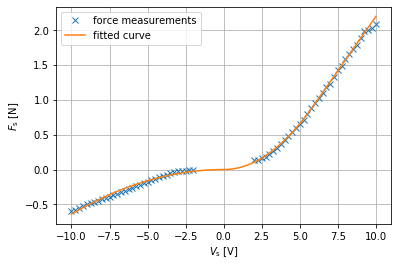

In [2]:
matfile = loadmat('../matlab/rotor_force_analysis/data_for_python')
vsfs_data = matfile['combined_normalized_data']
p1 = float(matfile['p1_opt'])
q1 = float(matfile['q1_opt'])
p2 = float(matfile['p2_opt'])
q2 = float(matfile['q2_opt'])

vs_plot = np.linspace(-10, 10, 101)
Fs_plot = np.array([Fr(vs, p1, q1, p2, q2) for vs in vs_plot])

plt.figure()
plt.plot(vsfs_data[:, 0], vsfs_data[:, 1], 'x', label='force measurements')
plt.plot(vs_plot, Fs_plot, label='fitted curve')
plt.legend()
plt.grid()
plt.xlabel('$V_\\mathrm{s}$ [V]')
plt.ylabel('$F_\\mathrm{s}$ [N]')

my_savefig('force_curve')
plt.show()

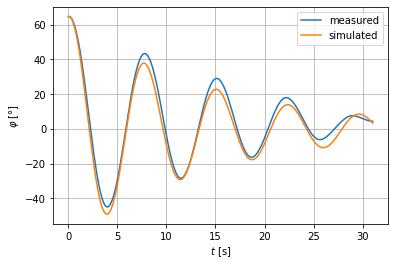

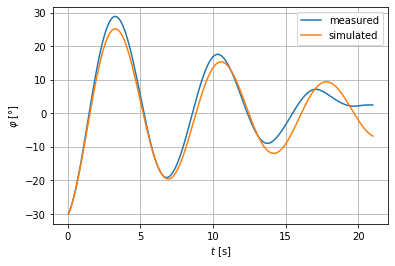

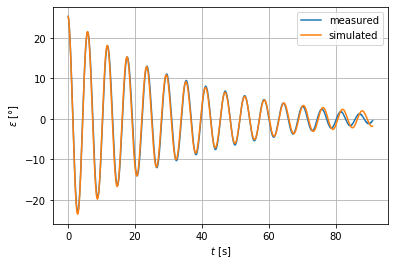

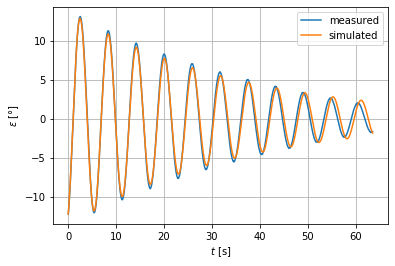

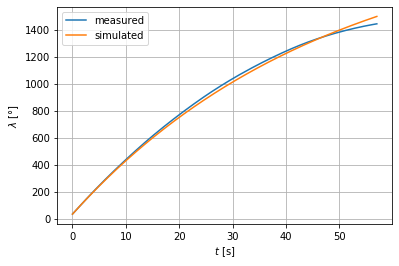

In [3]:
plt.figure()
plot_est('est_mu_phi.mat', 0, 'varphi', False)
my_savefig('est_mu_phi_0')

plt.figure()
plot_est('est_mu_phi.mat', 1, 'varphi', False)
my_savefig('est_mu_phi_1')

plt.figure()
plot_est('est_mu_eps.mat', 0, 'varepsilon', False)
my_savefig('est_mu_eps_0')

plt.figure()
plot_est('est_mu_eps.mat', 1, 'varepsilon', False)
my_savefig('est_mu_eps_1')

plt.figure()
plot_est('est_mu_lamb.mat', 0, 'lambda', False)
my_savefig('est_mu_lamb')

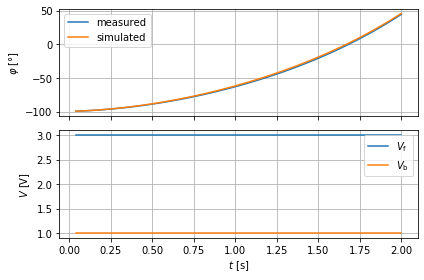

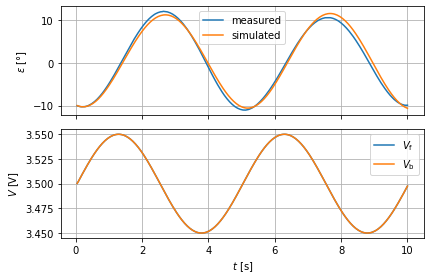

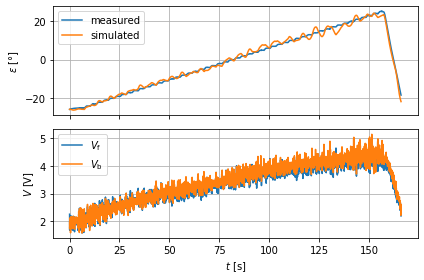

In [4]:
# p_eps_1: good looking 58, 57, 53, 
# p_eps_2 and p_eps_3: 2

plt.figure()
plot_est('est_p_phi_1_p_phi_2.mat', 3, 'varphi', True)
my_savefig('est_p_phi_1_p_phi_2_clip_3')

plt.figure()
plot_est('est_p_eps_1.mat', 53, 'varepsilon', True)
my_savefig('est_p_eps_1_clip_53')

plt.figure()
plot_est('est_p_eps_2_p_eps_3_NICE.mat', 0, 'varepsilon', True)
my_savefig('est_p_eps_2_p_eps_3_NICE')

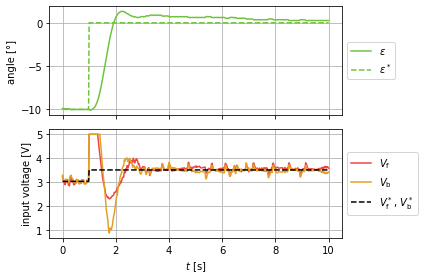

In [5]:
meas = load_meas('pid_1.1_HIGH')
clip = clip_and_unify(meas, -1, 9)

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
eps_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, eps_traj/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
plt.grid()
plt.legend(**leg)
plt.ylabel("angle [°]")
plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(-10*deg) if t < clip.traj_start else static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

squeeze_subplots()
my_savefig('pid_1.1')

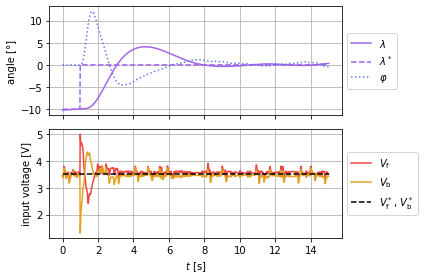

In [6]:
meas = load_meas('pid_1.2.2_LOW')
clip = clip_and_unify(meas, -1, 14)

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, lamb_traj/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color, ls='dotted')
plt.grid()
plt.legend(**leg)
plt.ylabel("angle [°]")

plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

squeeze_subplots()
my_savefig('pid_1.2.2')

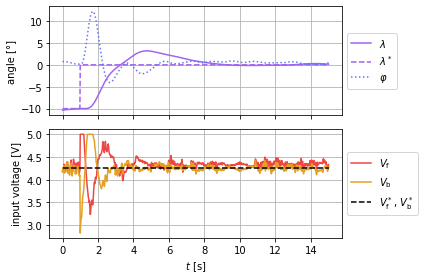

In [51]:
meas = load_meas('pid_1.2.3.1_LOW')
clip = clip_and_unify(meas, -1, 14)

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, lamb_traj/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color, ls='dotted')
plt.grid()
plt.legend(**leg)
plt.ylabel("angle [°]")

plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(20*deg) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

squeeze_subplots()
my_savefig('pid_1.2.3.1')

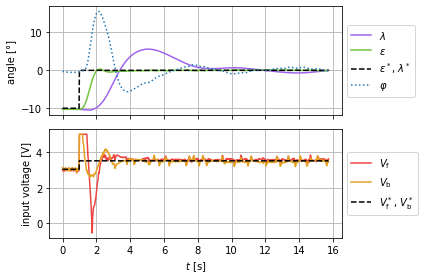

In [7]:
meas = load_meas('pid_1.3_LOW')
clip = clip_and_unify(meas, -1, 29)

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
eps_lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, eps_lamb_traj/deg, label="$\\varepsilon^*$, $\\lambda^*$", color='black', ls='--')
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", ls='dotted')
plt.grid()
plt.legend(**leg)
plt.ylabel("angle [°]")

plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(-10*deg) if t < clip.traj_start else static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

squeeze_subplots()
my_savefig('pid_1.3')

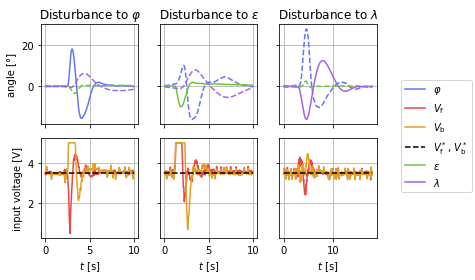

In [8]:
fig = plt.figure(figsize=(5.5, 4))

ax1 = plt.subplot(231)
meas = load_meas('pid_1.4_2_LOW')
clip = clip_and_unify(meas, 105, 115, False)
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color)
plt.plot(clip.t, clip.eps/deg, linestyle='--', **eps_color)
plt.plot(clip.t, clip.lamb/deg, linestyle='--', **lamb_color)
plt.grid()
plt.ylabel("angle [°]")
plt.title('Disturbance to $\\varphi$')

ax4 = plt.subplot(234, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', linestyle='--')
plt.grid()
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')

ax2 = plt.subplot(232, sharey=ax1)
clip = clip_and_unify(meas, 22.5, 32.5, False)
plt.plot(clip.t, clip.phi/deg, linestyle='--', **phi_color)
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
plt.plot(clip.t, clip.lamb/deg, linestyle='--', **lamb_color)
label_and_stuff(label_y=False, legend=False)
plt.title('Disturbance to $\\varepsilon$')

plt.subplot(235, sharex=ax2, sharey=ax4)
plt.plot(clip.t, clip.vf, **vf_color)
plt.plot(clip.t, clip.vb, **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, color='black', linestyle='--')
plt.grid()
plt.xlabel("$t$ [s]")

ax3 = plt.subplot(233, sharey=ax1)
clip = clip_and_unify(meas, 52, 70, False)
plt.plot(clip.t, clip.phi/deg, linestyle='--', **phi_color)
plt.plot(clip.t, clip.eps/deg, linestyle='--', **eps_color)
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
label_and_stuff(label_y=False, legend=False)
plt.title('Disturbance to $\\lambda$')

plt.subplot(236, sharex=ax3, sharey=ax4)
plt.plot(clip.t, clip.vf, **vf_color)
plt.plot(clip.t, clip.vb, **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, color='black', linestyle='--')
plt.grid()
plt.xlabel("$t$ [s]")

fig.legend(**leg)
squeeze_subplots()

my_savefig('pid_1.4')

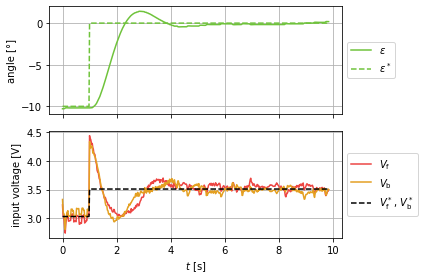

In [9]:
meas = load_meas('lqr_1.1')
clip = clip_and_unify(meas, -1, 9)

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
eps_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, eps_traj/deg, label="$\\varepsilon^*$", **eps_color, linestyle='--')
plt.grid()
plt.legend(**leg)
plt.ylabel("angle [°]")
plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(-10*deg) if t < clip.traj_start else static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

squeeze_subplots()
my_savefig('lqr_1.1')

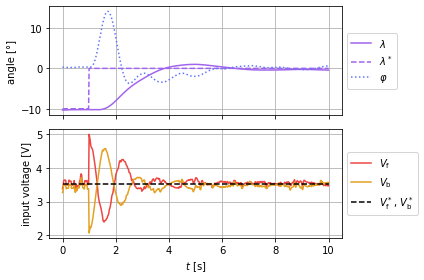

In [10]:
meas = load_meas('lqr_1.2.2_NEW')
clip = clip_and_unify(meas, -1, 9)

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, lamb_traj/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color, ls='dotted')
plt.grid()
plt.legend(**leg)
plt.ylabel("angle [°]")

plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

squeeze_subplots()
my_savefig('lqr_1.2.2')

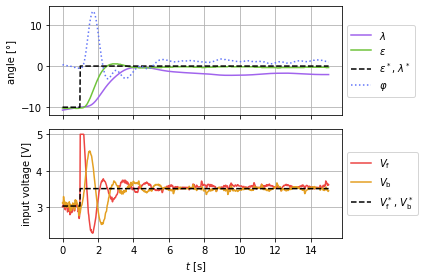

In [11]:
meas = load_meas('lqr_1.3_NEW')
clip = clip_and_unify(meas, -1, 14)

plt.figure(figsize=(6, 4))
ax1 = plt.subplot(211)
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
eps_lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, eps_lamb_traj/deg, label="$\\varepsilon^*$, $\\lambda^*$", color='black', ls='--')
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color, ls='dotted')
plt.grid()
plt.legend(**leg)
plt.ylabel("angle [°]")

plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(-10*deg) if t < clip.traj_start else static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

squeeze_subplots()
my_savefig('lqr_1.3')

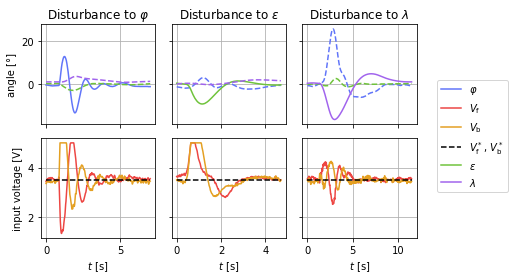

In [12]:
fig = plt.figure(figsize=(6, 4))

ax1 = plt.subplot(231)
meas = load_meas('lqr_1.4_NEW')
clip = clip_and_unify(meas, 47, 54, False)
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color)
plt.plot(clip.t, clip.eps/deg, linestyle='--', **eps_color)
plt.plot(clip.t, clip.lamb/deg, linestyle='--', **lamb_color)
plt.grid()
plt.ylabel("angle [°]")
plt.title('Disturbance to $\\varphi$')

ax4 = plt.subplot(234, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', linestyle='--')
plt.grid()
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')

ax2 = plt.subplot(232, sharey=ax1)
meas = load_meas('lqr_1.4_VID')
clip = clip_and_unify(meas, 17.3, 22, False)
plt.plot(clip.t, clip.phi/deg, linestyle='--', **phi_color)
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
plt.plot(clip.t, clip.lamb/deg, linestyle='--', **lamb_color)
label_and_stuff(label_y=False, legend=False)
plt.title('Disturbance to $\\varepsilon$')

plt.subplot(235, sharex=ax2, sharey=ax4)
plt.plot(clip.t, clip.vf, **vf_color)
plt.plot(clip.t, clip.vb, **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, color='black', linestyle='--')
plt.grid()
plt.xlabel("$t$ [s]")

ax3 = plt.subplot(233, sharey=ax1)
meas = load_meas('lqr_1.4_NEW')
clip = clip_and_unify(meas, 36, 47.5, False)
plt.plot(clip.t, clip.phi/deg, linestyle='--', **phi_color)
plt.plot(clip.t, clip.eps/deg, linestyle='--', **eps_color)
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
label_and_stuff(label_y=False, legend=False)
plt.title('Disturbance to $\\lambda$')

plt.subplot(236, sharex=ax3, sharey=ax4)
plt.plot(clip.t, clip.vf, **vf_color)
plt.plot(clip.t, clip.vb, **vb_color)
v_traj = np.array([static_ff_voltage(0) for t in clip.t])
plt.plot(clip.t, v_traj, color='black', linestyle='--')
plt.grid()
plt.xlabel("$t$ [s]")

squeeze_subplots()
fig.legend(**leg)

my_savefig('lqr_1.4')

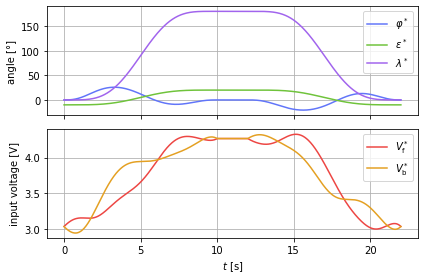

In [13]:
plt.figure(figsize=(6, 4))
meas = load_meas('pid_2.1.2_HIGH')
clip = clip_and_unify(meas, clip_end=22)

ax1 = plt.subplot(211)
plt.plot(clip.t, clip.traj_phi[:, 0]/deg, label="$\\varphi^*$", **phi_color)
plt.plot(clip.t, clip.traj_eps[:, 0]/deg, label="$\\varepsilon^*$", **eps_color)
plt.plot(clip.t, clip.traj_lamb[:, 0]/deg, label="$\\lambda^*$", **lamb_color)
plt.ylabel("angle [°]")
plt.grid()
plt.legend()

plt.subplot(212, sharex=ax1)
plt.plot(clip.t, clip.traj_vf, label="$V_\\mathrm{f}^*$", **vf_color)
plt.plot(clip.t, clip.traj_vb, label="$V_\\mathrm{b}^*$", **vb_color)
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend()

squeeze_subplots()

my_savefig('example_traj')

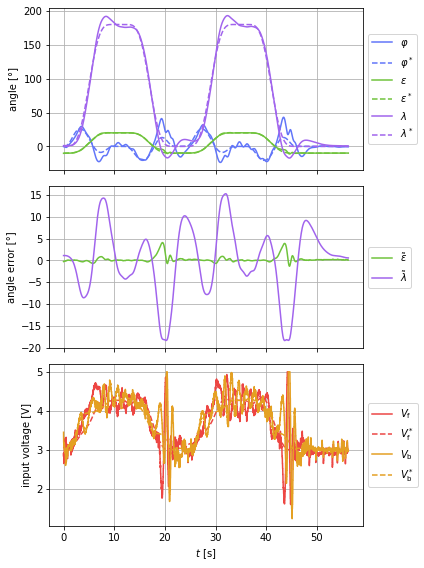

In [14]:
plt.figure(figsize=(6, 8))
meas = load_meas('pid_2.1.2_HIGH')
clip = clip_and_unify(meas)
plot_traj(clip)
my_savefig('pid_2.1.2')

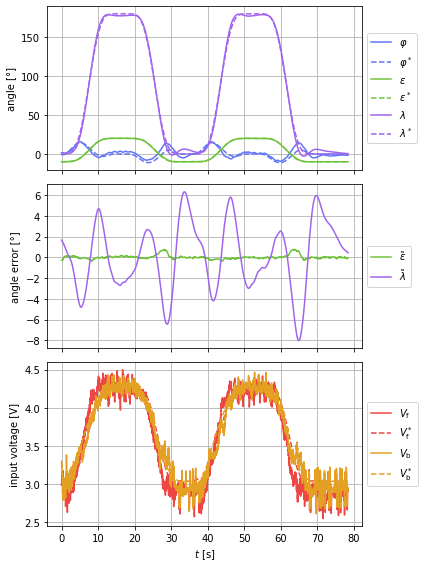

In [15]:
plt.figure(figsize=(6, 8))
meas = load_meas('pid_2.1.4_HIGH')
clip = clip_and_unify(meas)
plot_traj(clip)
my_savefig('pid_2.1.4')

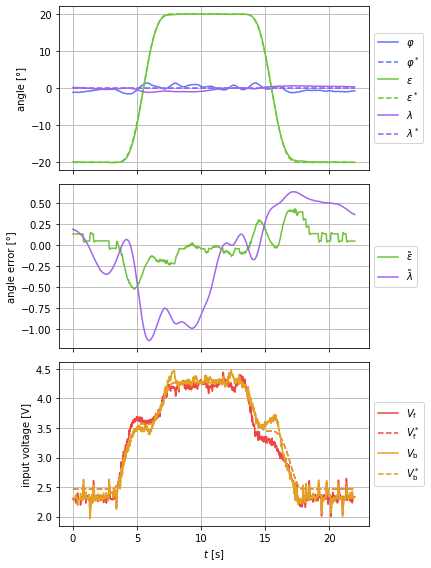

In [16]:
plt.figure(figsize=(6, 8))
meas = load_meas('pid_2.2.1_HIGH')
clip = clip_and_unify(meas, 17, 17+22)
plot_traj(clip)
my_savefig('pid_2.2.1')

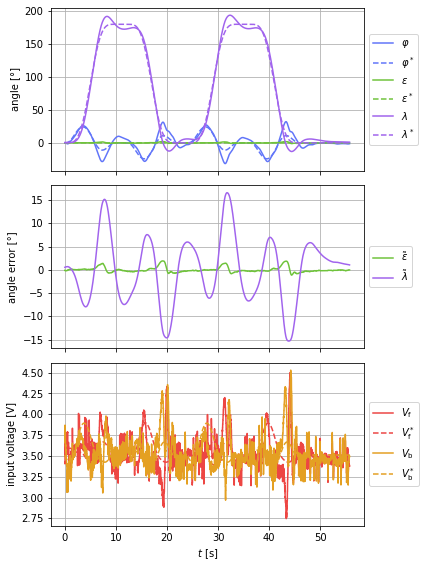

In [17]:
plt.figure(figsize=(6, 8))
meas = load_meas('pid_2.3.2_HIGH')
clip = clip_and_unify(meas)
plot_traj(clip)
my_savefig('pid_2.3.2')

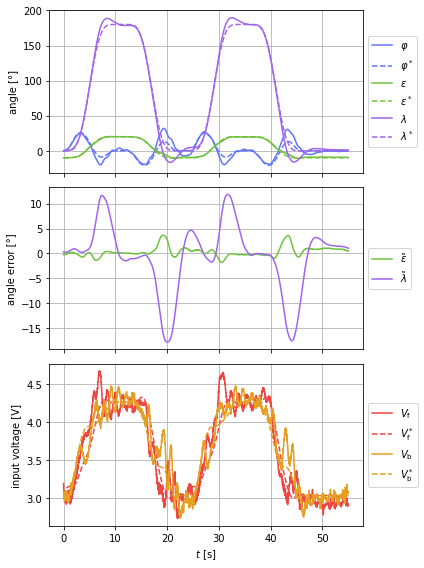

In [18]:
plt.figure(figsize=(6, 8))
meas = load_meas('lqr_2.1.2_NEW')
clip = clip_and_unify(meas, 0, 55)
plot_traj(clip)
my_savefig('lqr_2.1.2')

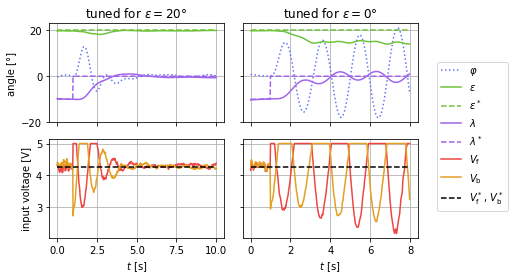

In [27]:
fig = plt.figure(figsize=(6, 4))

ax1 = plt.subplot(221)
meas = load_meas('lqr_1.2.3.2_NEW')
clip = clip_and_unify(meas, -1, 9)
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color, ls='dotted')
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
eps_traj = np.array([20*deg for t in clip.t])
plt.plot(clip.t, eps_traj/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, lamb_traj/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.grid()
plt.ylabel("angle [°]")
plt.title("tuned for $\\varepsilon=20$°")

ax2=plt.subplot(223, sharex=ax1)
plt.plot(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
v_traj = np.array([static_ff_voltage(20*deg) for t in clip.t])
plt.plot(clip.t, v_traj, label="$V_\\mathrm{f}^*$, $V_\\mathrm{b}^*$", color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.ylabel('input voltage [V]')
plt.grid()

ax3 = plt.subplot(222, sharey=ax1)
meas = load_meas('lqr_1.2.3.1_NEW')
clip = clip_and_unify(meas, -1)
plt.plot(clip.t, clip.phi/deg, **phi_color, ls='dotted')
plt.plot(clip.t, clip.eps/deg, **eps_color)
eps_traj = np.array([20*deg for t in clip.t])
plt.plot(clip.t, eps_traj/deg, **eps_color, ls='--')
plt.plot(clip.t, clip.lamb/deg, **lamb_color)
lamb_traj = np.array([-10*deg if t < clip.traj_start else 0 for t in clip.t])
plt.plot(clip.t, lamb_traj/deg, **lamb_color, ls='--')
plt.grid()
plt.title("tuned for $\\varepsilon=0$°")

plt.subplot(224, sharex=ax3, sharey=ax2)
plt.plot(clip.t, clip.vf, **vf_color)
plt.plot(clip.t, clip.vb, **vb_color)
v_traj = np.array([static_ff_voltage(20*deg) for t in clip.t])
plt.plot(clip.t, v_traj, color='black', ls='--')
plt.xlabel("$t$ [s]")
plt.grid()

squeeze_subplots()
fig.legend(**leg)

my_savefig('lqr_step_eps_tuning')

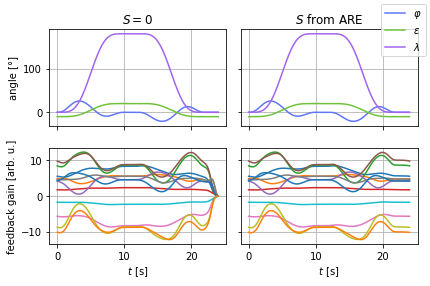

In [28]:
fig = plt.figure(figsize=(6, 4))

mat = loadmat('../matlab/riccati_sol_for_s_0.mat')

t_traj = mat['t'].flatten()
phi = mat['phi']
eps = mat['eps']
lamb = mat['lamb']

t_ricc = mat['riccati_tau'].flatten()
K_traj = mat['K_traj']

ax1 = plt.subplot(221)
plt.plot(t_traj, phi[:, 0]/deg, **phi_color, label='$\\varphi$')
plt.plot(t_traj, eps[:, 0]/deg, **eps_color, label='$\\varepsilon$')
plt.plot(t_traj, lamb[:, 0]/deg, **lamb_color, label='$\\lambda$')
plt.grid()
plt.ylabel('angle [°]')
plt.title('$S=0$')

ax2 = plt.subplot(223, sharex = ax1)
plt.plot(t_ricc, K_traj.reshape(K_traj.shape[0], 12))
plt.grid()
plt.xlabel('$t$ [s]')
plt.ylabel('feedback gain [arb. u.]')


mat = loadmat('../matlab/riccati_sol_for_s_auto.mat')

t_traj = mat['t'].flatten()
phi = mat['phi']
eps = mat['eps']
lamb = mat['lamb']

t_ricc = mat['riccati_tau'].flatten()
K_traj = mat['K_traj']

ax3 = plt.subplot(222, sharey=ax1)
plt.plot(t_traj, phi[:, 0]/deg, **phi_color)
plt.plot(t_traj, eps[:, 0]/deg, **eps_color)
plt.plot(t_traj, lamb[:, 0]/deg, **lamb_color)
plt.grid()
plt.title('$S$ from ARE')

plt.subplot(224, sharex=ax3, sharey=ax2)
plt.plot(t_ricc, K_traj.reshape(K_traj.shape[0], 12))
plt.grid()
plt.xlabel('$t$ [s]')

fig.legend()

squeeze_subplots()
my_savefig('riccati_sol_demo')

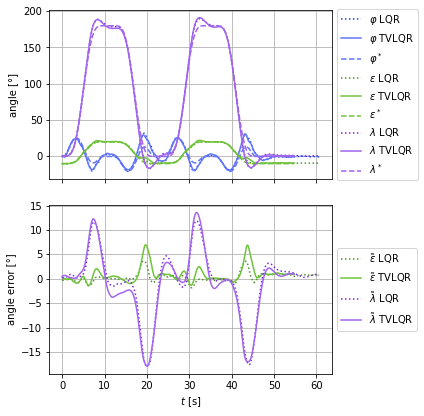

In [46]:
meas = load_meas('lqr_2.1.2_NEW')
lqr = clip_and_unify(meas)
meas = load_meas('tvlqr_2.1.2')
tvlqr = clip_and_unify(meas)

plt.figure(figsize=(6, 6))

ax1 = plt.subplot(211)
plt.plot(lqr.t, lqr.phi/deg, **phi_alt_color, ls='dotted', label=r"$\varphi$ LQR")
plt.plot(tvlqr.t, tvlqr.phi/deg, **phi_color, label=r"$\varphi$ TVLQR")
plt.plot(tvlqr.t, tvlqr.traj_phi[:, 0]/deg, **phi_color, ls='--', label=r"$\varphi^*$")
plt.plot(lqr.t, lqr.eps/deg, **eps_alt_color, ls='dotted', label=r"$\varepsilon$ LQR")
plt.plot(tvlqr.t, tvlqr.eps/deg, **eps_color, label=r"$\varepsilon$ TVLQR")
plt.plot(tvlqr.t, tvlqr.traj_eps[:, 0]/deg, **eps_color, ls='--', label=r"$\varepsilon^*$")
plt.plot(lqr.t, lqr.lamb/deg, **lamb_alt_color, ls='dotted', label=r"$\lambda$ LQR")
plt.plot(tvlqr.t, tvlqr.lamb/deg, **lamb_color, label=r"$\lambda$ TVLQR")
plt.plot(tvlqr.t, tvlqr.traj_lamb[:, 0]/deg, **lamb_color, ls='--', label=r"$\lambda^*$")
plt.grid()
plt.legend(**leg)
plt.ylabel('angle [°]')

plt.subplot(212, sharex=ax1)
plt.plot(lqr.t, (lqr.eps - lqr.traj_eps[:, 0])/deg, **eps_alt_color, ls='dotted', label=r"$\tilde\varepsilon$ LQR")
plt.plot(tvlqr.t, (tvlqr.eps - tvlqr.traj_eps[:, 0])/deg, **eps_color, label=r"$\tilde\varepsilon$ TVLQR")
plt.plot(lqr.t, (lqr.lamb - lqr.traj_lamb[:, 0])/deg, **lamb_alt_color, ls='dotted', label=r"$\tilde\lambda$ LQR")
plt.plot(tvlqr.t, (tvlqr.lamb - tvlqr.traj_lamb[:, 0])/deg, **lamb_color, label=r"$\tilde\lambda$ TVLQR")
plt.grid()
plt.legend(**leg)
plt.xlabel('$t$ [s]')
plt.ylabel('angle error [°]')

squeeze_subplots()
my_savefig('lqr_tvlqr_2.1.2')

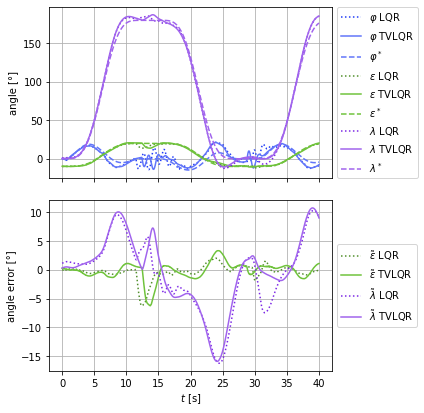

In [47]:
meas = load_meas('lqr_2.4.2_NEW')
lqr = clip_and_unify(meas, clip_end=40)
meas = load_meas('tvlqr_2.4.2')
tvlqr = clip_and_unify(meas, clip_end=40)

plt.figure(figsize=(6, 6))

ax1 = plt.subplot(211)
plt.plot(lqr.t, lqr.phi/deg, **phi_alt_color, ls='dotted', label=r"$\varphi$ LQR")
plt.plot(tvlqr.t, tvlqr.phi/deg, **phi_color, label=r"$\varphi$ TVLQR")
plt.plot(tvlqr.t, tvlqr.traj_phi[:, 0]/deg, **phi_color, ls='--', label=r"$\varphi^*$")
plt.plot(lqr.t, lqr.eps/deg, **eps_alt_color, ls='dotted', label=r"$\varepsilon$ LQR")
plt.plot(tvlqr.t, tvlqr.eps/deg, **eps_color, label=r"$\varepsilon$ TVLQR")
plt.plot(tvlqr.t, tvlqr.traj_eps[:, 0]/deg, **eps_color, ls='--', label=r"$\varepsilon^*$")
plt.plot(lqr.t, lqr.lamb/deg, **lamb_alt_color, ls='dotted', label=r"$\lambda$ LQR")
plt.plot(tvlqr.t, tvlqr.lamb/deg, **lamb_color, label=r"$\lambda$ TVLQR")
plt.plot(tvlqr.t, tvlqr.traj_lamb[:, 0]/deg, **lamb_color, ls='--', label=r"$\lambda^*$")
plt.grid()
plt.legend(**leg)
plt.ylabel('angle [°]')

plt.subplot(212, sharex=ax1)
plt.plot(lqr.t, (lqr.eps - lqr.traj_eps[:, 0])/deg, **eps_alt_color, ls='dotted', label=r"$\tilde\varepsilon$ LQR")
plt.plot(tvlqr.t, (tvlqr.eps - tvlqr.traj_eps[:, 0])/deg, **eps_color, label=r"$\tilde\varepsilon$ TVLQR")
plt.plot(lqr.t, (lqr.lamb - lqr.traj_lamb[:, 0])/deg, **lamb_alt_color, ls='dotted', label=r"$\tilde\lambda$ LQR")
plt.plot(tvlqr.t, (tvlqr.lamb - tvlqr.traj_lamb[:, 0])/deg, **lamb_color, label=r"$\tilde\lambda$ TVLQR")
plt.grid()
plt.legend(**leg)
plt.xlabel('$t$ [s]')
plt.ylabel('angle error [°]')

squeeze_subplots()
my_savefig('lqr_tvlqr_2.4.2')

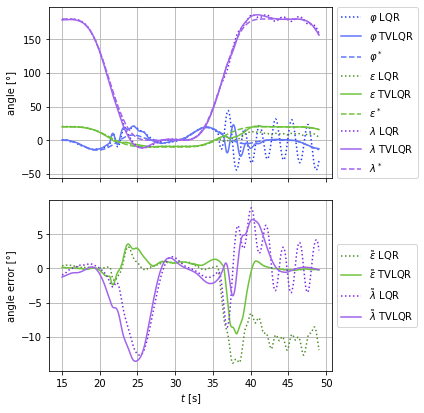

In [48]:
meas = load_meas('lqr_2.4.1_NEW')
lqr = clip_and_unify(meas, 15)
meas = load_meas('tvlqr_2.4.1')
tvlqr = clip_and_unify(meas, 15, 15+lqr.traj_end)

plt.figure(figsize=(6, 6))

ax1 = plt.subplot(211)
plt.plot(lqr.t+15, lqr.phi/deg, **phi_alt_color, ls='dotted', label=r"$\varphi$ LQR")
plt.plot(tvlqr.t+15, tvlqr.phi/deg, **phi_color, label=r"$\varphi$ TVLQR")
plt.plot(tvlqr.t+15, tvlqr.traj_phi[:, 0]/deg, **phi_color, ls='--', label=r"$\varphi^*$")
plt.plot(lqr.t+15, lqr.eps/deg, **eps_alt_color, ls='dotted', label=r"$\varepsilon$ LQR")
plt.plot(tvlqr.t+15, tvlqr.eps/deg, **eps_color, label=r"$\varepsilon$ TVLQR")
plt.plot(tvlqr.t+15, tvlqr.traj_eps[:, 0]/deg, **eps_color, ls='--', label=r"$\varepsilon^*$")
plt.plot(lqr.t+15, lqr.lamb/deg, **lamb_alt_color, ls='dotted', label=r"$\lambda$ LQR")
plt.plot(tvlqr.t+15, tvlqr.lamb/deg, **lamb_color, label=r"$\lambda$ TVLQR")
plt.plot(tvlqr.t+15, tvlqr.traj_lamb[:, 0]/deg, **lamb_color, ls='--', label=r"$\lambda^*$")
plt.grid()
plt.legend(**leg)
plt.ylabel('angle [°]')

plt.subplot(212, sharex=ax1)
plt.plot(lqr.t+15, (lqr.eps - lqr.traj_eps[:, 0])/deg, **eps_alt_color, ls='dotted', label=r"$\tilde\varepsilon$ LQR")
plt.plot(tvlqr.t+15, (tvlqr.eps - tvlqr.traj_eps[:, 0])/deg, **eps_color, label=r"$\tilde\varepsilon$ TVLQR")
plt.plot(lqr.t+15, (lqr.lamb - lqr.traj_lamb[:, 0])/deg, **lamb_alt_color, ls='dotted', label=r"$\tilde\lambda$ LQR")
plt.plot(tvlqr.t+15, (tvlqr.lamb - tvlqr.traj_lamb[:, 0])/deg, **lamb_color, label=r"$\tilde\lambda$ TVLQR")
plt.grid()
plt.legend(**leg)
plt.xlabel('$t$ [s]')
plt.ylabel('angle error [°]')

squeeze_subplots()
my_savefig('lqr_tvlqr_2.4.1')

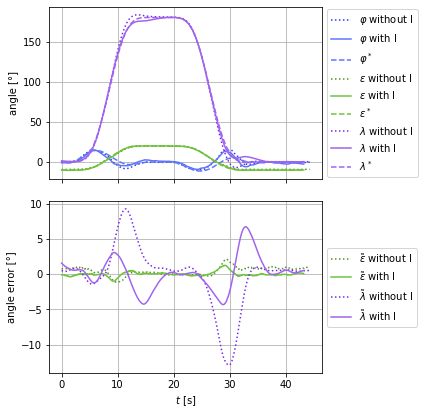

In [49]:
meas = load_meas('tvlqr_2.1.4')
without_i = clip_and_unify(meas, 35)
meas = load_meas('tvlqri_2.1.4_LOW')
with_i = clip_and_unify(meas, 35)

plt.figure(figsize=(6, 6))

ax1 = plt.subplot(211)
plt.plot(without_i.t, without_i.phi/deg, **phi_alt_color, ls='dotted', label=r"$\varphi$ without I")
plt.plot(with_i.t, with_i.phi/deg, **phi_color, label=r"$\varphi$ with I")
plt.plot(with_i.t, with_i.traj_phi[:, 0]/deg, **phi_color, ls='--', label=r"$\varphi^*$")
plt.plot(without_i.t, without_i.eps/deg, **eps_alt_color, ls='dotted', label=r"$\varepsilon$ without I")
plt.plot(with_i.t, with_i.eps/deg, **eps_color, label=r"$\varepsilon$ with I")
plt.plot(with_i.t, with_i.traj_eps[:, 0]/deg, **eps_color, ls='--', label=r"$\varepsilon^*$")
plt.plot(without_i.t, without_i.lamb/deg, **lamb_alt_color, ls='dotted', label=r"$\lambda$ without I")
plt.plot(with_i.t, with_i.lamb/deg, **lamb_color, label=r"$\lambda$ with I")
plt.plot(with_i.t, with_i.traj_lamb[:, 0]/deg, **lamb_color, ls='--', label=r"$\lambda^*$")
plt.grid()
plt.legend(**leg)
plt.ylabel('angle [°]')

plt.subplot(212, sharex=ax1)
plt.plot(without_i.t, (without_i.eps - without_i.traj_eps[:, 0])/deg, **eps_alt_color, ls='dotted', label=r"$\tilde\varepsilon$ without I")
plt.plot(with_i.t, (with_i.eps - with_i.traj_eps[:, 0])/deg, **eps_color, label=r"$\tilde\varepsilon$ with I")
plt.plot(without_i.t, (without_i.lamb - without_i.traj_lamb[:, 0])/deg, **lamb_alt_color, ls='dotted', label=r"$\tilde\lambda$ without I")
plt.plot(with_i.t, (with_i.lamb - with_i.traj_lamb[:, 0])/deg, **lamb_color, label=r"$\tilde\lambda$ with I")
plt.grid()
plt.legend(**leg)
plt.xlabel('$t$ [s]')
plt.ylabel('angle error [°]')

squeeze_subplots()
my_savefig('tvlqr_tvlqri_2.1.4')

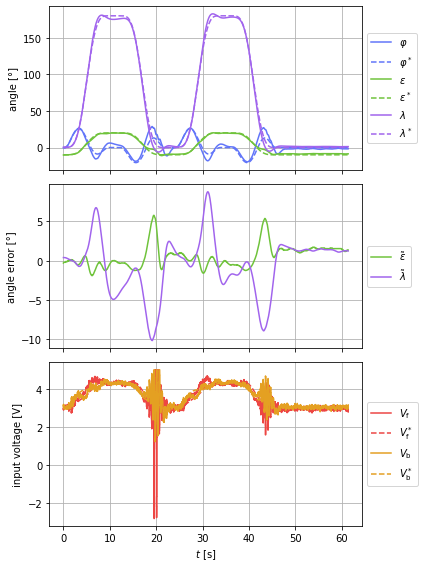

In [33]:
meas = load_meas('dynext_ode_2.1.2_1')
clip = clip_and_unify(meas)
plt.figure(figsize=(6, 8))
plot_traj(clip)
my_savefig('dynext_ode_2.1.2')

c:\dev\python\python_science\lib\site-packages\scipy\io\matlab\mio.py:218: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


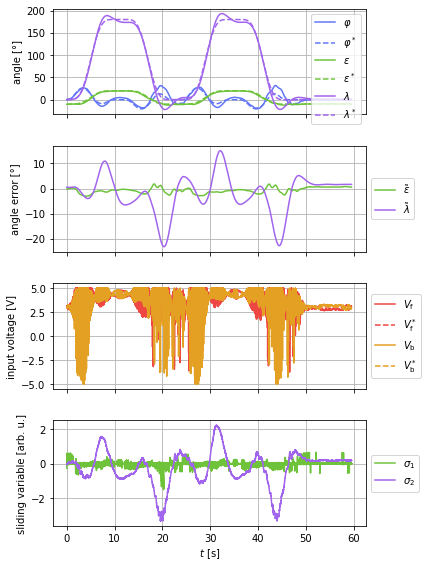

In [34]:
meas = load_meas('dynext_smc_2.1.2')
clip = clip_and_unify(meas)

mat = loadmat('../matlab/measurements/dynext_smc_2.1.2')
debug_3d = mat['debug_out']['signals'][0, 0]['values'][0, 0]
debug = np.reshape(debug_3d, (debug_3d.shape[0], debug_3d.shape[2]))
debug_t = mat['debug_out']['time'][0, 0].flatten()
# 36-43: phi(x)
# 24: sigma1
# 25: sigma2

plt.figure(figsize=(6, 8))

ax1 = plt.subplot(411)
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color)
plt.plot(clip.t, clip.traj_phi[:, 0]/deg, label="$\\varphi^*$", **phi_color, ls='--')
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
plt.plot(clip.t, clip.traj_eps[:, 0]/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
plt.plot(clip.t, clip.traj_lamb[:, 0]/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.ylabel("angle [°]")
plt.grid()
plt.legend()

plt.subplot(412, sharex=ax1)
plt.plot(clip.t, (clip.eps - clip.traj_eps[:, 0])/deg, label="$\\tilde\\varepsilon$", **eps_color)
plt.plot(clip.t, (clip.lamb - clip.traj_lamb[:, 0])/deg, label="$\\tilde\\lambda$", **lamb_color)
plt.ylabel("angle error [°]")
plt.grid()
plt.legend(**leg)

plt.subplot(413, sharex=ax1)
plt.step(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.traj_vf, label="$V_\\mathrm{f}^*$", **vf_color, ls='--')
plt.step(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
plt.plot(clip.t, clip.traj_vb, label="$V_\\mathrm{b}^*$", **vb_color, ls='--')
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

plt.subplot(414, sharex=ax1)
plt.plot(debug_t - debug_t[0], debug[24,:].T, **eps_color, label='$\\sigma_1$')
plt.plot(debug_t - debug_t[0], debug[25,:].T, **lamb_color, label='$\\sigma_2$')

plt.legend(**leg)
plt.xlabel("$t$ [s]")
plt.ylabel('sliding variable [arb. u.]')
plt.grid()

squeeze_subplots()
my_savefig('dynext_smc_2.1.2')

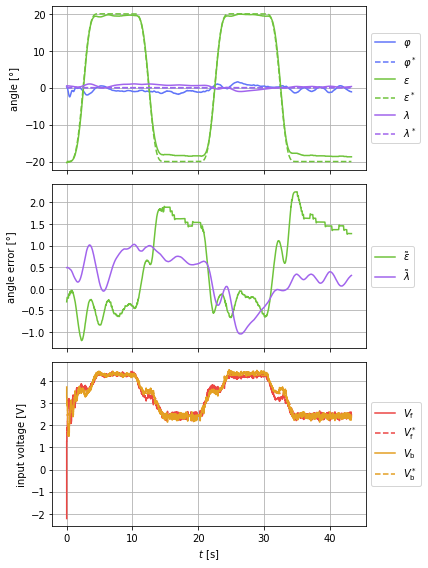

In [35]:
meas = load_meas('dynext_ode_2.2.1')
clip = clip_and_unify(meas)
plt.figure(figsize=(6, 8))
plot_traj(clip)
my_savefig('dynext_ode_2.2.1')

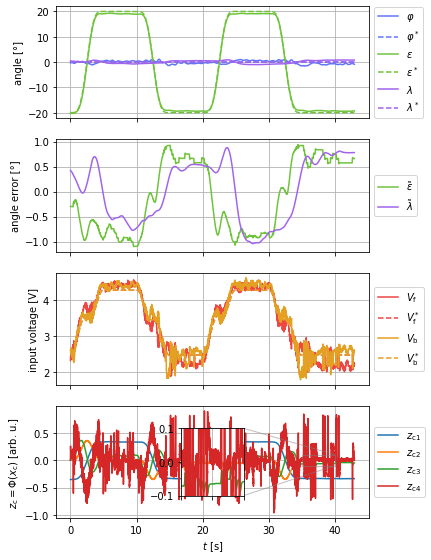

In [36]:
meas = load_meas('dynext_smc_2.2.1')
clip = clip_and_unify(meas)

mat = loadmat('../matlab/measurements/dynext_smc_2.2.1')
debug_3d = mat['debug_out']['signals'][0, 0]['values'][0, 0]
debug = np.reshape(debug_3d, (debug_3d.shape[0], debug_3d.shape[2]))
debug_t = mat['debug_out']['time'][0, 0].flatten()
# 36-43: phi(x)
# 24: sigma1
# 25: sigma2

plt.figure(figsize=(6, 8))

ax1 = plt.subplot(411)
plt.plot(clip.t, clip.phi/deg, label="$\\varphi$", **phi_color)
plt.plot(clip.t, clip.traj_phi[:, 0]/deg, label="$\\varphi^*$", **phi_color, ls='--')
plt.plot(clip.t, clip.eps/deg, label="$\\varepsilon$", **eps_color)
plt.plot(clip.t, clip.traj_eps[:, 0]/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
plt.plot(clip.t, clip.lamb/deg, label="$\\lambda$", **lamb_color)
plt.plot(clip.t, clip.traj_lamb[:, 0]/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.ylabel("angle [°]")
plt.grid()
plt.legend(**leg)

plt.subplot(412, sharex=ax1)
plt.plot(clip.t, (clip.eps - clip.traj_eps[:, 0])/deg, label="$\\tilde\\varepsilon$", **eps_color)
plt.plot(clip.t, (clip.lamb - clip.traj_lamb[:, 0])/deg, label="$\\tilde\\lambda$", **lamb_color)
plt.ylabel("angle error [°]")
plt.grid()
plt.legend(**leg)

plt.subplot(413, sharex=ax1)
plt.step(clip.t, clip.vf, label="$V_\\mathrm{f}$", **vf_color)
plt.plot(clip.t, clip.traj_vf, label="$V_\\mathrm{f}^*$", **vf_color, ls='--')
plt.step(clip.t, clip.vb, label="$V_\\mathrm{b}$", **vb_color)
plt.plot(clip.t, clip.traj_vb, label="$V_\\mathrm{b}^*$", **vb_color, ls='--')
plt.ylabel('input voltage [V]')
plt.grid()
plt.legend(**leg)

#plt.subplot(414, sharex=ax1)
##plt.plot(debug_t - debug_t[0], debug[24:26,:].T)
#plt.xlabel("$t$ [s]")
#plt.ylabel("sliding variable")
#plt.grid()
#plt.legend(['$\\sigma_1$', '$\\sigma_2$'])

ax3 = plt.subplot(414, sharex=ax1)
plt.plot(debug_t - debug_t[0], debug[36:40,:].T)
plt.xlabel("$t$ [s]")
plt.ylabel("$z_\\mathrm{c}=\\Phi(x_\\mathrm{c})$ [arb. u.]")
plt.grid()
plt.legend(["$z_{\\mathrm{c}1}$", "$z_{\\mathrm{c}2}$", "$z_{\\mathrm{c}3}$", "$z_{\\mathrm{c}4}$"], **leg)

axins = ax3.inset_axes([0.4, 0.2, 0.2, 0.6])
axins.step(debug_t - debug_t[0], debug[36:40,:].T)
axins.grid()
axins.set_xlim(35, 40)
axins.set_ylim(-0.1, 0.1)
axins.set_xticklabels('')
#axins.set_yticklabels('')
ax3.indicate_inset_zoom(axins)

squeeze_subplots()

my_savefig('dynext_smc_2.2.1')

Simulation stuff

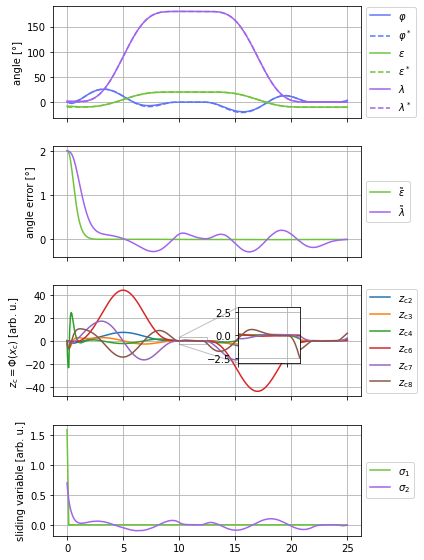

In [37]:
mat = loadmat('../matlab/smc_perfect_sim.mat')
t = mat['traj_samples']['time'][0, 0].flatten()
traj = mat['traj_samples']['signals'][0, 0]['values'][0, 0]
x_sim = mat['x_sim']['signals'][0, 0]['values'][0, 0]
z_from_x = mat['z_from_x']['signals'][0, 0]['values'][0, 0].squeeze().T
z_est = mat['z_est']['signals'][0, 0]['values'][0, 0].squeeze().T
sigma = mat['sigma']['signals'][0, 0]['values'][0, 0].squeeze().T

# was will ich für plots haben?
# eps und lamb verlauf
# regelabweichung
# geschätzte ableitungen für eps
# verlauf für sliding-variablen
plt.figure(figsize=(6, 8))

ax1 = plt.subplot(411)
plt.plot(t, x_sim[:, 0]/deg, label="$\\varphi$", **phi_color)
plt.plot(t, traj[:, 2]/deg, label="$\\varphi^*$", **phi_color, ls='--')
plt.plot(t, x_sim[:, 1]/deg, label="$\\varepsilon$", **eps_color)
plt.plot(t, traj[:, 3]/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
plt.plot(t, x_sim[:, 2]/deg, label="$\\lambda$", **lamb_color)
plt.plot(t, traj[:, 4]/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.ylabel("angle [°]")
plt.grid()
plt.legend(**leg)

plt.subplot(412, sharex=ax1)
plt.plot(t, (x_sim[:, 1] - traj[:, 3])/deg, label="$\\tilde\\varepsilon$", **eps_color)
plt.plot(t, (x_sim[:, 2] - traj[:, 4])/deg, label="$\\tilde\\lambda$", **lamb_color)
plt.ylabel("angle error [°]")
plt.grid()
plt.legend(**leg)

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(t, z_from_x[:, 1:4]/deg)
plt.plot(t, z_from_x[:, 5:8]/deg)
plt.grid()
plt.ylabel("$z_\\mathrm{c}=\\Phi(x_\\mathrm{c})$ [arb. u.]")
plt.legend(["$z_{\\mathrm{c}2}$", "$z_{\\mathrm{c}3}$", "$z_{\\mathrm{c}4}$", "$z_{\\mathrm{c}6}$", "$z_{\\mathrm{c}7}$" ,"$z_{\\mathrm{c}8}$"], **leg)

axins = ax3.inset_axes([0.6, 0.3, 0.2, 0.5])
axins.plot(t, z_from_x[:, 1:4]/deg)
axins.plot(t, z_from_x[:, 5:8]/deg)
axins.grid()
axins.set_xlim(10, 12.5)
axins.set_ylim(-3, 3)
axins.set_xticklabels('')
#axins.set_yticklabels('')
ax3.indicate_inset_zoom(axins)

plt.subplot(414, sharex=ax1)
plt.plot(t, sigma[:, 0], **eps_color, label="$\\sigma_1$")
plt.plot(t, sigma[:, 1], **lamb_color, label="$\\sigma_2$")
plt.grid()
plt.legend(**leg)
plt.ylabel('sliding variable [arb. u.]')

squeeze_subplots()

my_savefig('smc_perfect_sim')

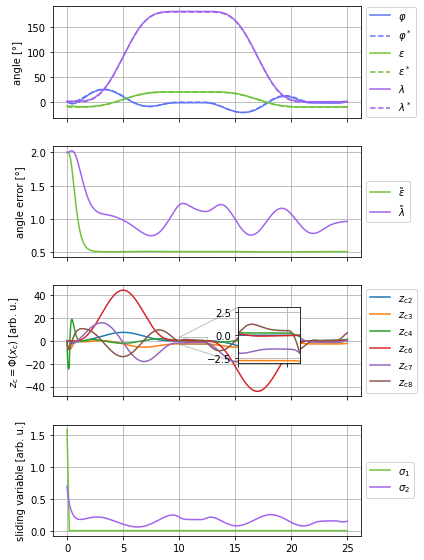

In [38]:
mat = loadmat('../matlab/smc_wrong_sim_no_obs.mat')
t = mat['traj_samples']['time'][0, 0].flatten()
traj = mat['traj_samples']['signals'][0, 0]['values'][0, 0]
x_sim = mat['x_sim']['signals'][0, 0]['values'][0, 0]
z_from_x = mat['z_from_x']['signals'][0, 0]['values'][0, 0].squeeze().T
z_est = mat['z_est']['signals'][0, 0]['values'][0, 0].squeeze().T
sigma = mat['sigma']['signals'][0, 0]['values'][0, 0].squeeze().T

# was will ich für plots haben?
# eps und lamb verlauf
# regelabweichung
# geschätzte ableitungen für eps
# verlauf für sliding-variablen
plt.figure(figsize=(6, 8))

ax1 = plt.subplot(411)
plt.plot(t, x_sim[:, 0]/deg, label="$\\varphi$", **phi_color)
plt.plot(t, traj[:, 2]/deg, label="$\\varphi^*$", **phi_color, ls='--')
plt.plot(t, x_sim[:, 1]/deg, label="$\\varepsilon$", **eps_color)
plt.plot(t, traj[:, 3]/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
plt.plot(t, x_sim[:, 2]/deg, label="$\\lambda$", **lamb_color)
plt.plot(t, traj[:, 4]/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.ylabel("angle [°]")
plt.grid()
plt.legend(**leg)

plt.subplot(412, sharex=ax1)
plt.plot(t, (x_sim[:, 1] - traj[:, 3])/deg, label="$\\tilde\\varepsilon$", **eps_color)
plt.plot(t, (x_sim[:, 2] - traj[:, 4])/deg, label="$\\tilde\\lambda$", **lamb_color)
plt.ylabel("angle error [°]")
plt.grid()
plt.legend(**leg)

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(t, z_from_x[:, 1:4]/deg)
plt.plot(t, z_from_x[:, 5:8]/deg)
plt.grid()
plt.ylabel("$z_\\mathrm{c}=\\Phi(x_\\mathrm{c})$ [arb. u.]")
plt.legend(["$z_{\\mathrm{c}2}$", "$z_{\\mathrm{c}3}$", "$z_{\\mathrm{c}4}$", "$z_{\\mathrm{c}6}$", "$z_{\\mathrm{c}7}$" ,"$z_{\\mathrm{c}8}$"], **leg)

axins = ax3.inset_axes([0.6, 0.3, 0.2, 0.5])
axins.plot(t, z_from_x[:, 1:4]/deg)
axins.plot(t, z_from_x[:, 5:8]/deg)
axins.grid()
axins.set_xlim(10, 12.5)
axins.set_ylim(-3, 3)
axins.set_xticklabels('')
#axins.set_yticklabels('')
ax3.indicate_inset_zoom(axins)

plt.subplot(414, sharex=ax1)
plt.plot(t, sigma[:, 0], **eps_color, label="$\\sigma_1$")
plt.plot(t, sigma[:, 1], **lamb_color, label="$\\sigma_2$")
plt.grid()
plt.legend(**leg)
plt.ylabel('sliding variable [arb. u.]')

squeeze_subplots()

my_savefig('smc_wrong_sim_no_obs')

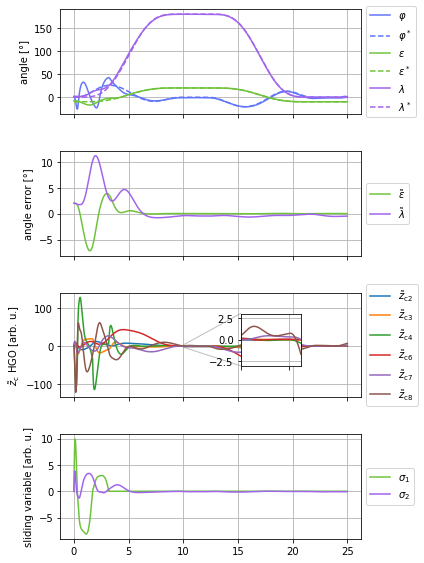

In [39]:
mat = loadmat('../matlab/smc_wrong_sim_with_obs.mat')
t = mat['traj_samples']['time'][0, 0].flatten()
traj = mat['traj_samples']['signals'][0, 0]['values'][0, 0]
x_sim = mat['x_sim']['signals'][0, 0]['values'][0, 0]
z_from_x = mat['z_from_x']['signals'][0, 0]['values'][0, 0].squeeze().T
z_est = mat['z_est']['signals'][0, 0]['values'][0, 0].squeeze().T
sigma = mat['sigma']['signals'][0, 0]['values'][0, 0].squeeze().T

# was will ich für plots haben?
# eps und lamb verlauf
# regelabweichung
# geschätzte ableitungen für eps
# verlauf für sliding-variablen
plt.figure(figsize=(6, 8))

ax1 = plt.subplot(411)
plt.plot(t, x_sim[:, 0]/deg, label="$\\varphi$", **phi_color)
plt.plot(t, traj[:, 2]/deg, label="$\\varphi^*$", **phi_color, ls='--')
plt.plot(t, x_sim[:, 1]/deg, label="$\\varepsilon$", **eps_color)
plt.plot(t, traj[:, 3]/deg, label="$\\varepsilon^*$", **eps_color, ls='--')
plt.plot(t, x_sim[:, 2]/deg, label="$\\lambda$", **lamb_color)
plt.plot(t, traj[:, 4]/deg, label="$\\lambda^*$", **lamb_color, ls='--')
plt.ylabel("angle [°]")
plt.grid()
plt.legend(**leg)

plt.subplot(412, sharex=ax1)
plt.plot(t, (x_sim[:, 1] - traj[:, 3])/deg, label="$\\tilde\\varepsilon$", **eps_color)
plt.plot(t, (x_sim[:, 2] - traj[:, 4])/deg, label="$\\tilde\\lambda$", **lamb_color)
plt.ylabel("angle error [°]")
plt.grid()
plt.legend(**leg)

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(t, z_est[:, 1:4]/deg)
plt.plot(t, z_est[:, 5:8]/deg)
plt.grid()
plt.ylabel("$\\tilde z_\\mathrm{c}$ HGO [arb. u.]")
plt.legend(["$\\tilde z_{\\mathrm{c}2}$", "$\\tilde z_{\\mathrm{c}3}$", "$\\tilde z_{\\mathrm{c}4}$", "$\\tilde z_{\\mathrm{c}6}$", "$\\tilde z_{\\mathrm{c}7}$" ,"$\\tilde z_{\\mathrm{c}8}$"], **leg)

axins = ax3.inset_axes([0.6, 0.3, 0.2, 0.5])
axins.plot(t, z_est[:, 1:4]/deg)
axins.plot(t, z_est[:, 5:8]/deg)
axins.grid()
axins.set_xlim(10, 12.5)
axins.set_ylim(-3, 3)
axins.set_xticklabels('')
#axins.set_yticklabels('')
ax3.indicate_inset_zoom(axins)

plt.subplot(414, sharex=ax1)
plt.plot(t, sigma[:, 0], **eps_color, label="$\\sigma_1$")
plt.plot(t, sigma[:, 1], **lamb_color, label="$\\sigma_2$")
plt.grid()
plt.legend(**leg)
plt.ylabel('sliding variable [arb. u.]')

squeeze_subplots()

my_savefig('smc_wrong_sim_with_obs')

Kalman Filter

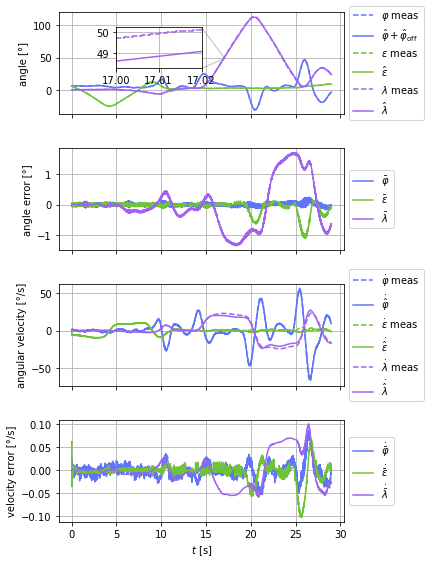

In [40]:
mat = loadmat('../matlab/kalman_verific.mat')

end_off = 500
t = mat['y_sample']['time'][0, 0].flatten()[:-end_off]
y_meas = mat['y_sample']['signals'][0, 0]['values'][0, 0][:-end_off, :]
y_bad_filter = mat['y_bad_filter']['signals'][0, 0]['values'][0, 0][:-end_off, :]
x_est = mat['x_est']['signals'][0, 0]['values'][0, 0][:-end_off, :]
dphi_filt = mat['dphi_filt'].flatten()[:-end_off]
deps_filt = mat['deps_filt'].flatten()[:-end_off]
dlamb_filt = mat['dlamb_filt'].flatten()[:-end_off]

plt.figure(figsize=(6, 8))

ax1 = plt.subplot(411)
plt.plot(t, y_meas[:, 0]/deg, **phi_color, ls='--', label='$\\varphi$ meas')
plt.plot(t, (x_est[:, 0] + x_est[:, 6])/deg, **phi_color, label='$\\hat\\varphi+\\hat\\varphi_\mathrm{off}$')
plt.plot(t, y_meas[:, 1]/deg, **eps_color, ls='--', label='$\\varepsilon$ meas')
plt.plot(t, x_est[:, 1]/deg, **eps_color, label="$\\hat\\varepsilon$")
plt.plot(t, y_meas[:, 2]/deg, **lamb_color, ls='--', label='$\\lambda$ meas')
plt.plot(t, x_est[:, 2]/deg, **lamb_color, label="$\\hat\\lambda$")
plt.grid()
plt.ylabel("angle [°]")
plt.legend(**leg)

axins = ax1.inset_axes([0.2, 0.45, 0.3, 0.4])
axins.step(t, y_meas[:, 2]/deg, **lamb_color, ls=(0, (5, 1)))
axins.plot(t, x_est[:, 2]/deg, **lamb_color)
axins.grid()
axins.set_xlim(17, 17.02)
axins.set_ylim(48.3, 50.2)
#axins.set_xticklabels('')
#axins.set_yticklabels('')
ax1.indicate_inset_zoom(axins)

plt.subplot(412, sharex=ax1)
plt.step(t, (x_est[:, 0] + x_est[:, 6] - y_meas[:, 0])/deg, **phi_color, label='$\\bar\\varphi$')
plt.step(t, (x_est[:, 1] - y_meas[:, 1])/deg, **eps_color, label='$\\bar\\varepsilon$')
plt.step(t, (x_est[:, 2] - y_meas[:, 2])/deg, **lamb_color, label='$\\bar\\lambda$')
plt.grid()
plt.ylabel("angle error [°]")
plt.legend(**leg)

plt.subplot(413, sharex=ax1)
plt.plot(t, dphi_filt/deg, **phi_color, ls='--', label='$\\dot\\varphi$ meas')
plt.plot(t, x_est[:, 3]/deg, **phi_color, label='$\\dot{\\hat\\varphi}$')
plt.plot(t, deps_filt/deg, **eps_color, ls='--', label='$\\dot\\varepsilon$ meas')
plt.plot(t, x_est[:, 4]/deg, **eps_color, label='$\\dot{\\hat\\varepsilon}$')
plt.plot(t, dlamb_filt/deg, **lamb_color, ls='--', label='$\\dot\\lambda$ meas')
plt.plot(t, x_est[:, 5]/deg, **lamb_color, label='$\\dot{\\hat\\lambda}$')
plt.legend(**leg)
plt.grid()
plt.ylabel("angular velocity [°/s]")

plt.subplot(414, sharex=ax1)
plt.plot(t, (x_est[:, 3] - dphi_filt), **phi_color, label='$\\dot{\\bar\\varphi}$')
plt.plot(t, (x_est[:, 4] - deps_filt), **eps_color, label='$\\dot{\\bar\\varepsilon}$')
plt.plot(t, (x_est[:, 5] - dlamb_filt), **lamb_color, label='$\\dot{\\bar\\lambda}$')
plt.grid()
plt.legend(**leg)
plt.ylabel("velocity error [°/s]")
plt.xlabel("$t$ [s]")

squeeze_subplots()

my_savefig('kalman_verific')

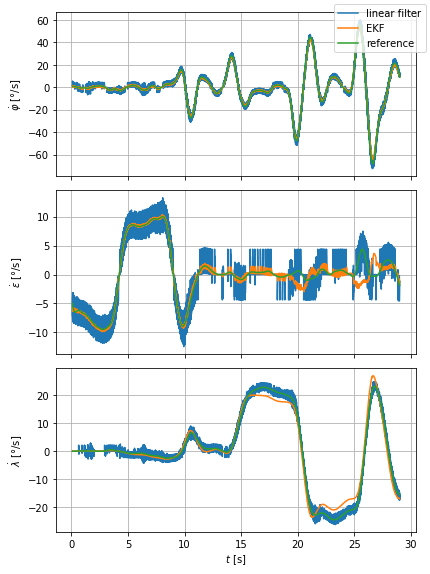

In [41]:
fig = plt.figure(figsize=(6, 8))

ax1 = plt.subplot(311)
plt.step(t[50:], y_bad_filter[50:, 0]/deg, label='linear filter')
plt.plot(t[50:], x_est[50:, 3]/deg, label='EKF')
plt.plot(t[50:], dphi_filt[50:]/deg, label='reference')
plt.grid()
plt.ylabel("$\\dot\\varphi$ [°/s]")

plt.subplot(312, sharex=ax1)
plt.step(t[50:], y_bad_filter[50:, 1]/deg)
plt.plot(t[50:], x_est[50:, 4]/deg)
plt.plot(t[50:], deps_filt[50:]/deg)
plt.grid()
plt.ylabel("$\\dot\\varepsilon$ [°/s]")

plt.subplot(313, sharex=ax1)
plt.step(t[50:], y_bad_filter[50:, 2]/deg)
plt.plot(t[50:], x_est[50:, 5]/deg)
plt.plot(t[50:], dlamb_filt[50:]/deg)
plt.grid()
plt.xlabel("$t$ [s]")
plt.ylabel("$\\dot\\lambda$ [°/s]")

fig.legend()

squeeze_subplots()
my_savefig('kalman_bad_filter_comparison')

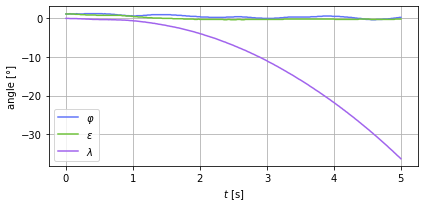

In [42]:
meas = load_meas('obs_phioff0_phi0.mat')
clip = clip_and_unify(meas, 66, 71, relative_to_traj_start=False)

plt.figure(figsize=(6, 3))
plt.plot(clip.t, clip.phi/deg, **phi_color, label="$\\varphi$")
plt.plot(clip.t, clip.eps/deg, **eps_color, label="$\\varepsilon$")
plt.plot(clip.t, (clip.lamb - clip.lamb[0])/deg, **lamb_color, label="$\\lambda$")
plt.grid()
plt.legend()
plt.xlabel("$t$ [s]")
plt.ylabel("angle [°]")

plt.tight_layout()
my_savefig('kalman_phi0_no_ekf')

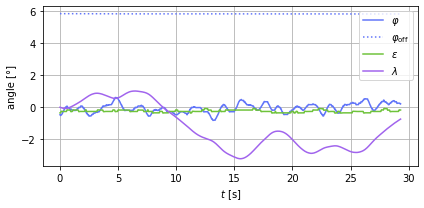

In [43]:
meas = load_meas('obs_phioff_ekf_phi0_1')
clip = clip_and_unify(meas, 120, 1000, relative_to_traj_start=False, normalize_t=True)

plt.figure(figsize=(6, 3))
plt.plot(clip.t, clip.phi/deg, **phi_color, label='$\\varphi$')
plt.plot(clip.t, clip.phioff/deg, ls='dotted', **phi_color, label='$\\varphi_\\mathrm{off}$')
plt.plot(clip.t, clip.eps/deg, **eps_color, label='$\\varepsilon$')
plt.plot(clip.t, (clip.lamb - clip.lamb[0])/deg, **lamb_color, label='$\\lambda$')
plt.grid()
plt.legend()
plt.xlabel("$t$ [s]")
plt.ylabel("angle [°]")

plt.tight_layout()
my_savefig('kalman_phi0_with_ekf')

Partlin

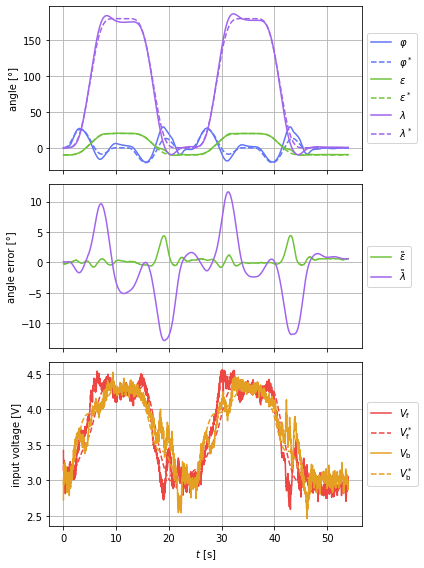

In [44]:
meas = load_meas('plin_2.1.2')
clip = clip_and_unify(meas)

plt.figure(figsize=(6, 8))
plot_traj(clip)
my_savefig('plin_2.1.2')

Vortrag

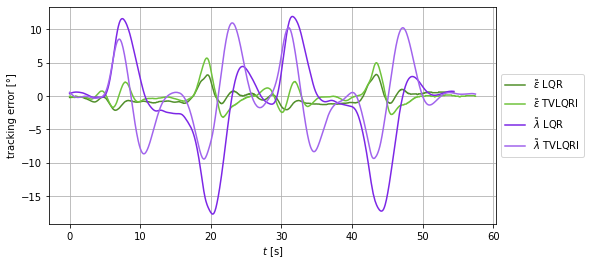

In [14]:
lqr = clip_and_unify(load_meas("lqr_2.1.2_VID"))
tvlqri = clip_and_unify(load_meas("tvlqri_2.1.2_VID"))

plt.figure(figsize=(8, 4))
plt.plot(lqr.t, (lqr.eps - lqr.traj_eps[:, 0]) / deg, **eps_alt_color, label=r"$\tilde\varepsilon$ LQR")
plt.plot(tvlqri.t, (tvlqri.eps - tvlqri.traj_eps[:, 0]) / deg, **eps_color, label=r"$\tilde\varepsilon$ TVLQRI")

plt.plot(lqr.t, (lqr.lamb - lqr.traj_lamb[:, 0]) / deg, **lamb_alt_color, label=r"$\tilde\lambda$ LQR")
plt.plot(tvlqri.t, (tvlqri.lamb - tvlqri.traj_lamb[:, 0]) / deg, **lamb_color, label=r"$\tilde\lambda$ TVLQRI")

plt.grid()
plt.legend(**leg)

plt.xlabel("$t$ [s]")
plt.ylabel("tracking error [°]")

my_savefig('praes_lqr_vs_tvlqri')

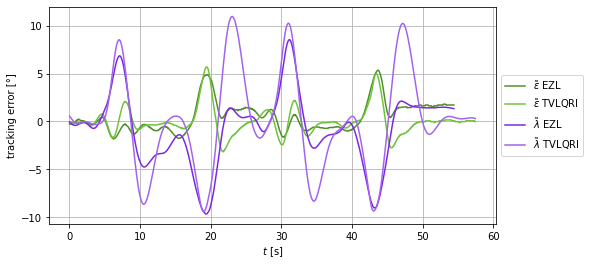

In [15]:
dynext = clip_and_unify(load_meas("dynext_ode_2.1.2_2"))
tvlqri = clip_and_unify(load_meas("tvlqri_2.1.2_VID"))

plt.figure(figsize=(8, 4))
plt.plot(dynext.t, (dynext.eps - dynext.traj_eps[:, 0]) / deg, **eps_alt_color, label=r"$\tilde\varepsilon$ EZL")
plt.plot(tvlqri.t, (tvlqri.eps - tvlqri.traj_eps[:, 0]) / deg, **eps_color, label=r"$\tilde\varepsilon$ TVLQRI")

plt.plot(dynext.t, (dynext.lamb - dynext.traj_lamb[:, 0]) / deg, **lamb_alt_color, label=r"$\tilde\lambda$ EZL")
plt.plot(tvlqri.t, (tvlqri.lamb - tvlqri.traj_lamb[:, 0]) / deg, **lamb_color, label=r"$\tilde\lambda$ TVLQRI")

plt.grid()
plt.legend(**leg)

plt.xlabel("$t$ [s]")
plt.ylabel("tracking error [°]")

my_savefig('praes_tvlqri_vs_dynext')

Tag der Fakultät

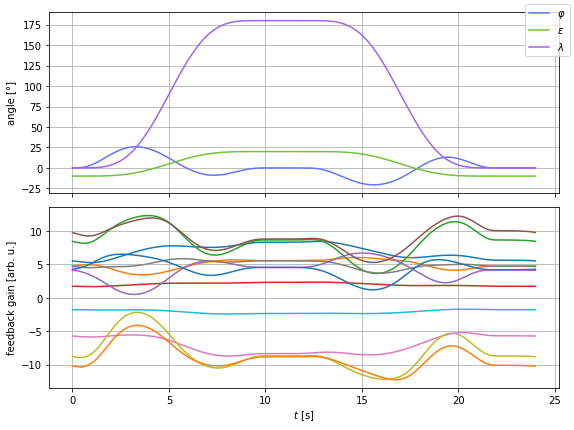

In [2]:
fig = plt.figure(figsize=(8, 6))

mat = loadmat('../matlab/riccati_sol_for_s_auto.mat')

t_traj = mat['t'].flatten()
phi = mat['phi']
eps = mat['eps']
lamb = mat['lamb']

t_ricc = mat['riccati_tau'].flatten()
K_traj = mat['K_traj']

ax1 = plt.subplot(211)
plt.plot(t_traj, phi[:, 0]/deg, **phi_color, label='$\\varphi$')
plt.plot(t_traj, eps[:, 0]/deg, **eps_color, label='$\\varepsilon$')
plt.plot(t_traj, lamb[:, 0]/deg, **lamb_color, label='$\\lambda$')
plt.grid()
plt.ylabel('angle [°]')

ax2 = plt.subplot(212, sharex = ax1)
plt.plot(t_ricc, K_traj.reshape(K_traj.shape[0], 12))
plt.grid()
plt.xlabel('$t$ [s]')
plt.ylabel('feedback gain [arb. u.]')

fig.legend()

squeeze_subplots()
my_savefig('riccati_sol_tdf')